In [64]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import datetime

In [65]:
data = load_breast_cancer()
X_train, X_val, y_train, y_val = train_test_split(data.data, data.target, random_state=0)

In [109]:
target = data.target

counts = pd.Series(target).value_counts()
print(counts)

1    357
0    212
dtype: int64


0 is malignant, 1 is benign

In [66]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train,y_train)
clf.feature_importances_

array([0.02515433, 0.01563844, 0.05372655, 0.04861645, 0.00769078,
       0.00936994, 0.05539489, 0.10305394, 0.0065771 , 0.00282708,
       0.02921459, 0.00607814, 0.01342868, 0.03420174, 0.00360641,
       0.00432096, 0.00448775, 0.00657502, 0.00460597, 0.00627095,
       0.11657269, 0.01603133, 0.16027724, 0.0634688 , 0.01356448,
       0.01164113, 0.03923725, 0.11711756, 0.01164259, 0.00960721])

### Tree’s Feature Importance from Mean Decrease in Impurity (MDI)

In [68]:
feature_names = data.feature_names

mdi_importances = pd.Series(
    clf.feature_importances_, index=feature_names
).sort_values(ascending=True)

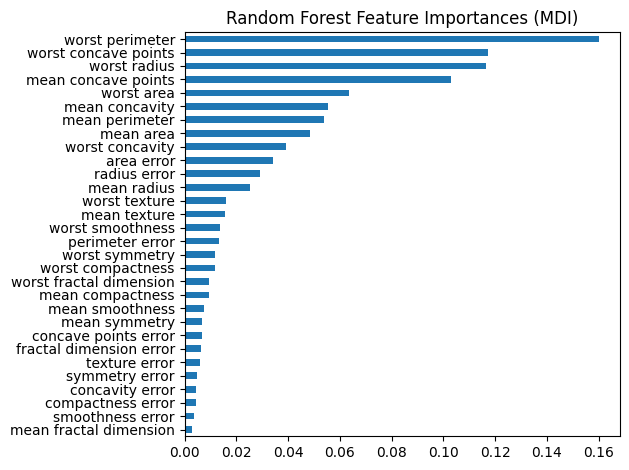

In [69]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()


i) A high MDI value (like Worst Perimeter) suggests that it is important for the classification task, while a feature with a low MDI value suggests that it is less important

### II) Permutation Importance

#####  Permutation Importance on the test set

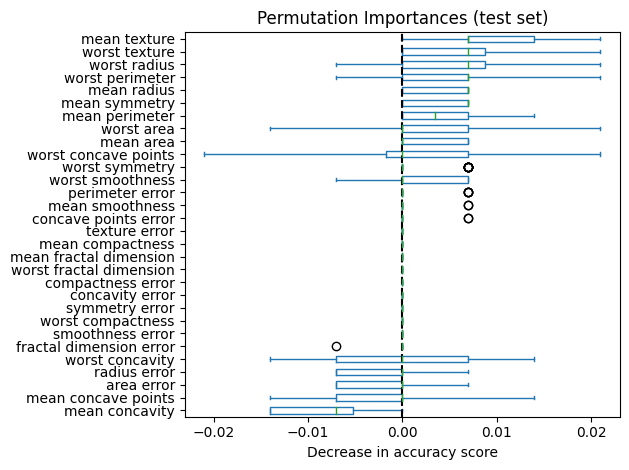

In [70]:
result = permutation_importance(
    clf, X_val, y_val, n_repeats=40, random_state=10, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


##### Permutation Importance on the Train Set

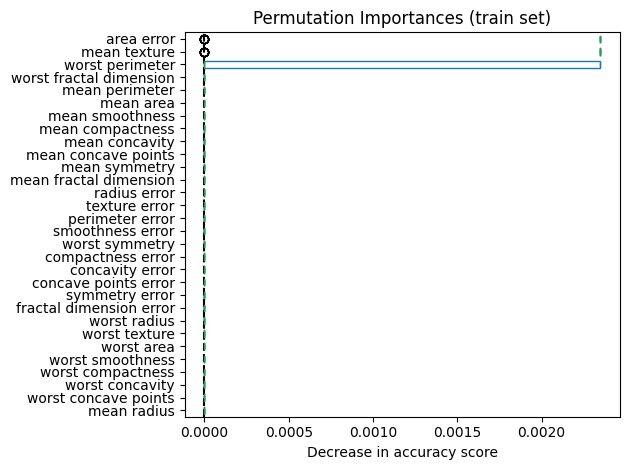

In [72]:
result = permutation_importance(
    clf, X_train, y_train, n_repeats=40, random_state=10, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=feature_names[sorted_importances_idx],
)


In [ ]:
III) 

### IV) SHAP for Tabular data

In [81]:
#!pip3 install shap

In [82]:
import shap
import matplotlib.pyplot as plt


# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = TreeExplainer(clf)

"""
Compute shap_values for all of X_test rather instead of 
a single row, to have more data for plot.
"""
shap_values = explainer.shap_values(X_val)

Variable Importance Plot - Global Interpretation


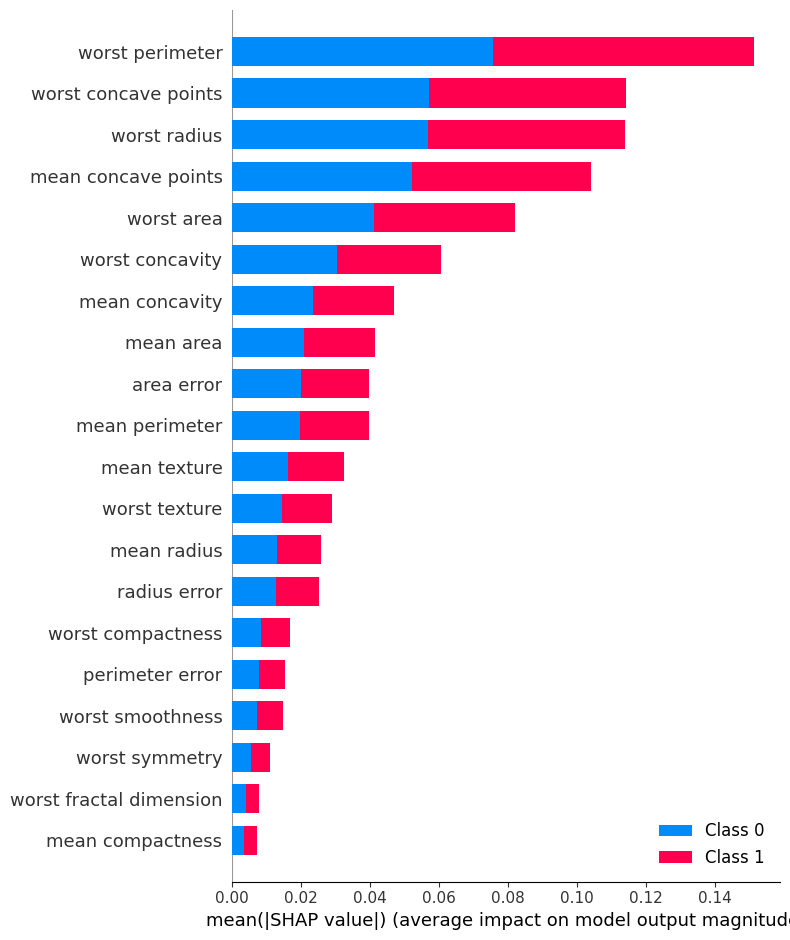

In [91]:
# Variable Importance With Summary Plot
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_val, feature_names=feature_names)

List of most important features, from most significant to the least significant one.
The colors seem to contribute in a equal manner since they occupy 50% of the rectangles. Worst Perimeter has the most predicative power according to this model

### Summary Plot on Positive(Malignant) Instances

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


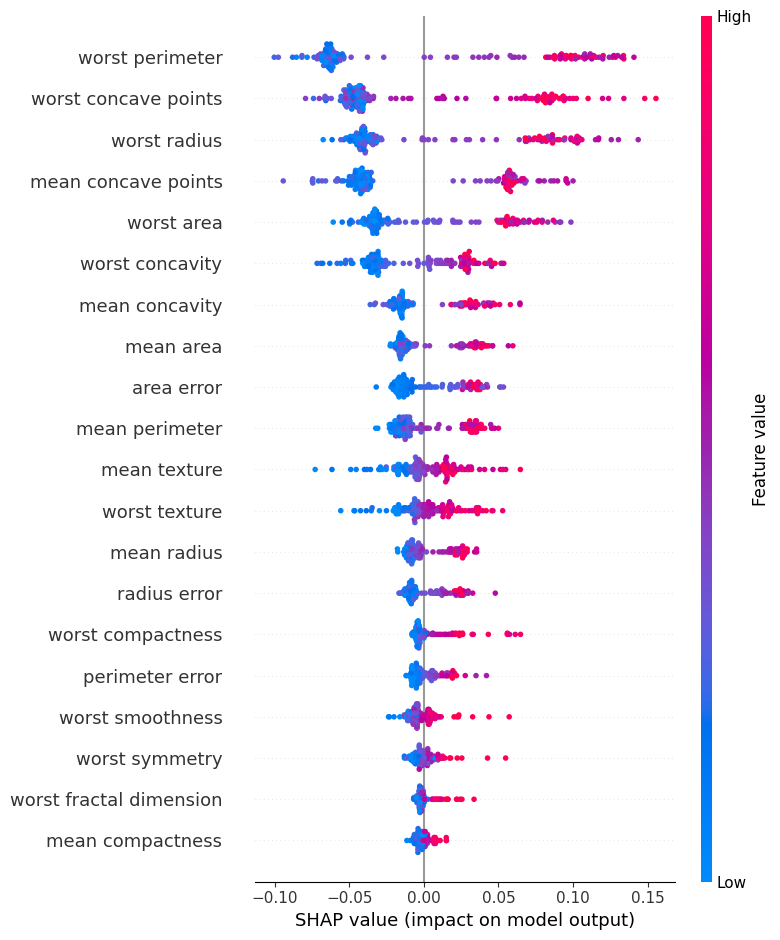

In [110]:
# Summary Plot Deep-Dive on Label 0
shap.summary_plot(shap_values[0], X_val, feature_names=feature_names)

We observe that the majority of the high value(red dots) have a postive contribution (postive on the X-axis) to the predicted output. This means that the worst perimeter observation for an individual data instance is high, its chance of having a postive outcome increases pretty strongly.

### Dependance Plot

In [115]:
feature_names = data.feature_names
print(feature_names)


['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


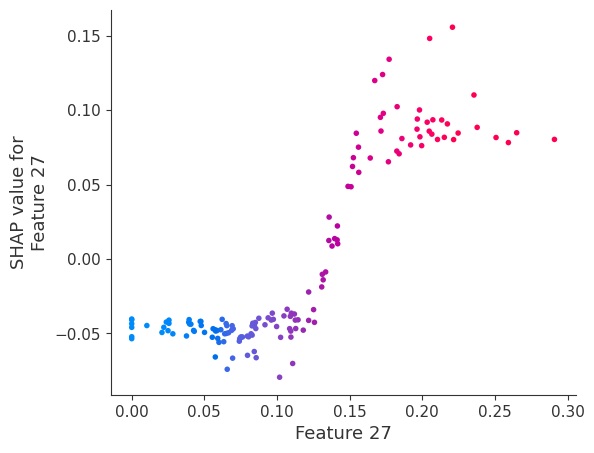

In [150]:
# Dependence Plot on Worst Concave Points feature
shap.dependence_plot(27, shap_values[0], X_val, interaction_index=27)

From the dependency plot, we can clearly see that a observation below 0.21 are lower risk of being diagnosed with maligant, whereas, those above this threshold have higher risk

### LIME for Tabular Data

In [151]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = data.target_names

# Fit the Explainer ozn the training data set using the LimeTabularExplainer 
explainer = LimeTabularExplainer(X_train, feature_names = feature_names, 
                                 class_names = class_names, mode = 'classification')

In [152]:
#Perform the explanation on the 1st instance in the test data
explaination = explainer.explain_instance(X_val[0], clf.predict_proba)

# show the result of the model's explaination
explaination.show_in_notebook(show_table = True, show_all = False)

The model predicts this observation to be malignant with 94% condidence. It explains the predicition because e.g the worst concave points are higher than 0.12 (0.21) 
On the right, we can observe the real features' value for the patient.

### Problem 2

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf


In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 /root/.kaggle/kaggle.json

In [13]:
! kaggle datasets download ashishsaxena2209/animal-image-datasetdog-cat-and-panda

animal-image-datasetdog-cat-and-panda.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
! unzip animal-image-datasetdog-cat-and-panda.zip

Archive:  animal-image-datasetdog-cat-and-panda.zip
replace animals/animals/cats/cats_00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
dir_ = os.path.join('/content/animals/animals')
train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split = 0.8)

In [37]:
train_generator = train_datagen.flow_from_directory(dir_,target_size=(100, 100),
                                                   batch_size= 1920,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset = 'training')

test_generator = train_datagen.flow_from_directory(dir_,
                                                          target_size = (100,100),
                                                          batch_size = 480,
                                                          class_mode = 'categorical',
                                                          shuffle=False,
                                                          subset = 'validation')


# Fetch the data and the labels
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

# Fix the filepath
test_filepath = []
for filepath in test_generator.filepaths:
    filepath = filepath.replace('\\', '/')
    test_filepath.append(filepath)

Found 600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


##### Create Model

In [38]:
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(3, activation='softmax') 
])

In [50]:
def run_model(model, train_x, train_y, validate_x, validate_y, batch_size, no_epochs):
    
    datetime_now = datetime.datetime.now()
    datetime_now = datetime_now.strftime("%Y_%m_%d_%H_%M_%S")
    print(datetime_now)
    os.makedirs('logs', exist_ok=True)
    os.makedirs('models', exist_ok=True)
    os.makedirs('models/' + str(datetime_now), exist_ok=True)
    
    filepath = 'models/' + str(datetime_now) + '/model-{epoch:02d}-{val_accuracy:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                                 save_best_only=False, mode='auto', period=1)
    
    checkpoint_best = ModelCheckpoint("models/best_model.hdf5", monitor='loss', verbose=1,
                                       save_best_only=True, mode='auto', period=1)
    
    csv_logger = CSVLogger('logs/model_history_log.log', separator=',', append=True)

    history = model.fit(train_x,
                        train_y,
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=1,
                        validation_data=(validate_x, validate_y),
                        callbacks=[checkpoint, checkpoint_best, csv_logger])

    pd.DataFrame(history.history).to_csv("logs/history.csv")
    model.save_weights('models/model_weights.h5')
    
    return history

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = run_model(model, x_train, y_train, x_test, y_test, batch_size=512, no_epochs=80)

2023_05_09_12_12_19
Epoch 1/80
2/2 [==============================] - ETA: 0s - loss: 0.8670 - accuracy: 0.5833
Epoch 1: saving model to models/2023_05_09_12_12_19/model-01-0.05.hdf5

Epoch 1: loss improved from inf to 0.86698, saving model to models/best_model.hdf5
2/2 [==============================] - 11s 3s/step - loss: 0.8670 - accuracy: 0.5833 - val_loss: 1.2167 - val_accuracy: 0.0479
Epoch 2/80
2/2 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.5767
Epoch 2: saving model to models/2023_05_09_12_12_19/model-02-0.07.hdf5

Epoch 2: loss improved from 0.86698 to 0.80462, saving model to models/best_model.hdf5
2/2 [==============================] - 10s 4s/step - loss: 0.8046 - accuracy: 0.5767 - val_loss: 0.9455 - val_accuracy: 0.0708
Epoch 3/80
2/2 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.6017
Epoch 3: saving model to models/2023_05_09_12_12_19/model-03-0.77.hdf5

Epoch 3: loss did not improve from 0.80462
2/2 [================

In [ ]:
"""# Loading and re-running the model
from keras.models import load_model

def load_trained_model(filepath):
    new_model = load_model(filepath)
    return model
    
model = load_trained_model("models/best_model.hdf5")"""

##### Prediction of Custom Model

In [ ]:
#! pip install scikit-image

In [184]:
from tensorflow.keras.applications import inception_v3 as inc_net
from skimage import io
from tensorflow.keras.preprocessing import image
from skimage import io, transform

url = 'https://raw.githubusercontent.com/marcellusruben/All_things_medium/main/Lime/panda_00024.jpg'

#also save image
def read_and_transform_img(url, save_path=None):
    img = io.imread(url)
    img = transform.resize(img, (100, 100))
    if save_path is not None:
        io.imsave(save_path, img)
    img = np.expand_dims(img, axis=0)
    return img
    
images = read_and_transform_img(url, 'panda_resized.jpg')

preds = model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

if prediction == 0:
    print('It\'s a cat!')
elif prediction == 1:
    print('It\'s a dog!')
else:
    print('It\'s a panda!')

#print(pct)

1/1 [==============================] - 0s 42ms/step
It's a panda!


In [ ]:
!pip install lime

## LIME with Our Model

In [200]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [201]:
# interpreting the prediction of our model
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


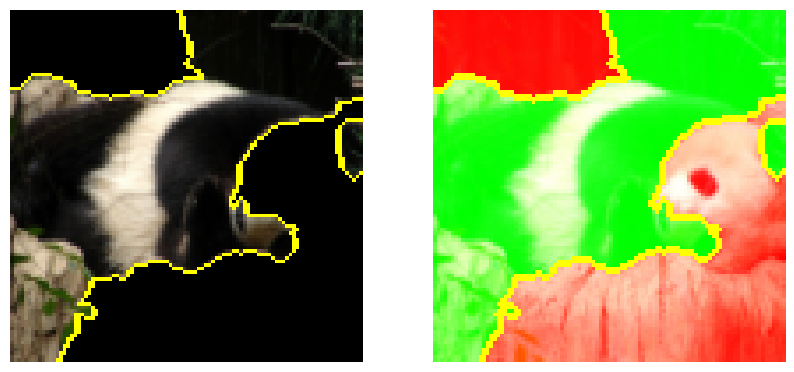

In [202]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default.png')


This means that our model classifies our image as a panda because of these parts of super-pixels.

### Lime for Pre-Trained Model

In [203]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def transform_img_fn_ori(url):
    
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (299,299))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = inet_model.predict(img)
    for i in decode_predictions(preds)[0]:
        print(i)
    return img

inet_model = inc_net.InceptionV3()
images_inc_im = transform_img_fn_ori(url)

1/1 [==============================] - 2s 2s/step
('n02510455', 'giant_panda', 0.9290502)
('n04266014', 'space_shuttle', 0.0027943577)
('n04254680', 'soccer_ball', 0.000826442)
('n02002556', 'white_stork', 0.00062917883)
('n02509815', 'lesser_panda', 0.0005990832)


In [ ]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), 
                                        inet_model.predict,  top_labels=3,
                                        hide_color=0, num_samples=1000)
 
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)


(-0.5, 298.5, 298.5, -0.5)

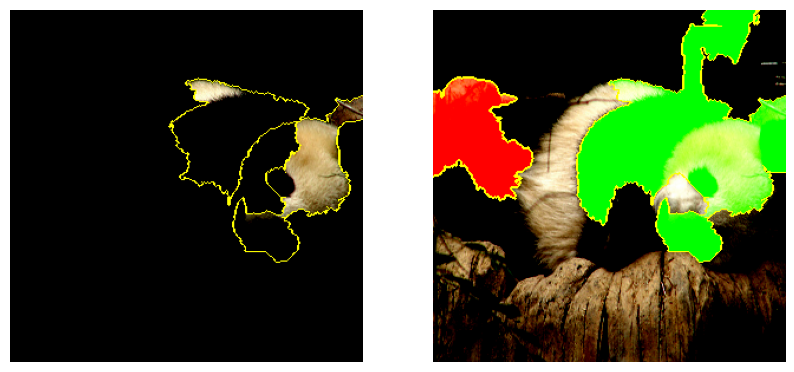

In [206]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

Both of the custom model and pre-trained InceptionV3 model are able to classify our image as a panda due to the specific features of a panda

### SHAP with Pre-Trained Model

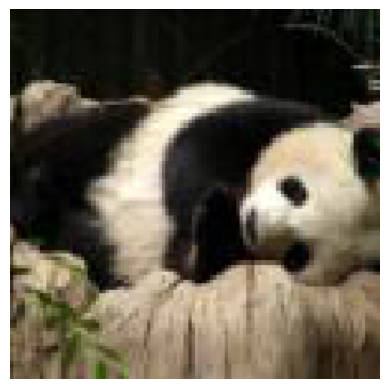

In [207]:
# load the image
file = "panda_resized.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)
plt.imshow(img);
plt.axis('off');

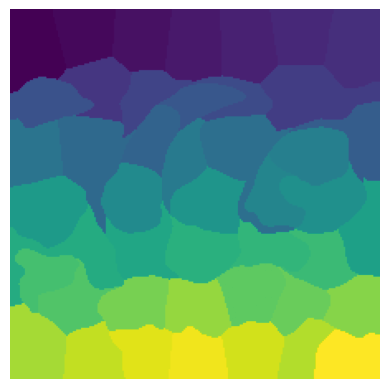

In [208]:
#Segment the image so we don’t have to explain every pixel.
from skimage.segmentation import slic
from keras.applications.vgg16 import preprocess_input 
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.axis('off');

In [209]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return inet_model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

In [229]:
# get the top predictions from the model
preds = inet_model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data=[preds[0, inds[i]] for i in range(5)])

1/1 [==============================] - 0s 264ms/step


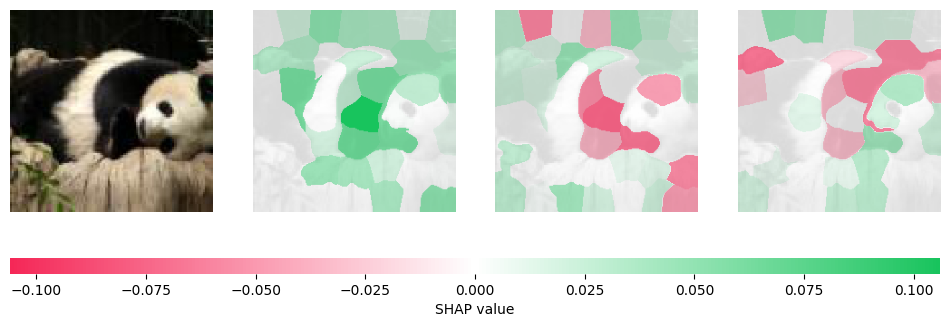

In [219]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

The following image is explained well in SHAP such as in LIME, giving similar results